<a href="https://colab.research.google.com/github/jvataidee/DataAnalysis/blob/master/Analise_Financeira_Mercado_Gado_de_Corte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_ce7cb603d09d4263921dda3fb68a395f~mv2.png" height="75px"></p>

**by: [João Ataíde](https://www.joaoataide.com)**
# Análise Mercado Financeira de Gado de Corte


---

<p align="center"><img src="https://static.wixstatic.com/media/bdd7cb_a59ef6dfb8914eea869878888a5d0acd~mv2.jpg"></p>



In [ ]:
!pip install investpy -q

     |████████████████████████████████| 4.4MB 4.2MB/s 
     |████████████████████████████████| 245kB 32.8MB/s 
     |████████████████████████████████| 6.3MB 40.8MB/s 
     |████████████████████████████████| 512kB 57.5MB/s 


In [ ]:
!pip install yfinance -q

In [ ]:
#importar bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as wb
import investpy
import yfinance as yf

# configurar a visualização
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
#Importar historico do dolar
doll = yf.Ticker("USDBRL=x")
dollar = doll.history(start ="2020-01-01", end ="2020-12-31" )
dollar.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01,4.016786,4.018200,4.016300,4.016786,0,0,0
2020-01-02,4.016300,4.038700,4.000820,4.016300,0,0,0
2020-01-03,4.023700,4.067005,4.021125,4.023400,0,0,0
2020-01-06,4.057000,4.066200,4.044942,4.057000,0,0,0
2020-01-07,4.060500,4.090600,4.043024,4.060400,0,0,0


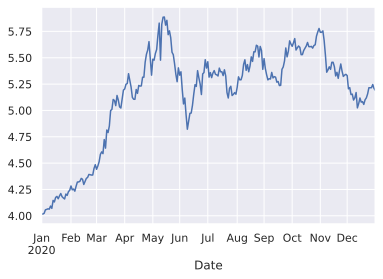

In [ ]:
dollar.Close.plot()

In [ ]:
#Importar historico do boi gordo
lcf = yf.Ticker("LE=F")
boi_gordo = lcf.history(start ="2020-01-01", end ="2020-12-31" )
boi_gordo.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,126.000000,126.324997,124.550003,125.775002,28659,0,0
2020-01-03,125.775002,125.949997,124.574997,124.724998,32902,0,0
2020-01-06,125.000000,127.425003,124.750000,127.275002,33907,0,0
2020-01-07,127.000000,127.250000,125.775002,126.525002,28583,0,0
2020-01-08,126.449997,126.949997,126.025002,126.349998,41439,0,0


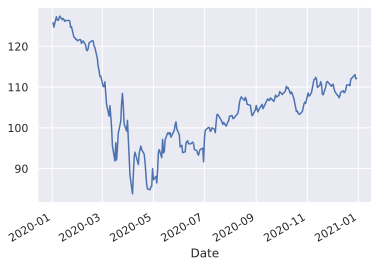

In [ ]:
boi_gordo.Close.plot()